# <span style="color:#0b486b">  FIT5215: Deep Learning (2023)</span>
***
*CE/Lecturer:* Dr **Trung Le** | trunglm@monash.edu <br/>
*Head Tutor:* Mr **Tuan Nguyen** | tuan.nguyen@monash.edu <br/>
<br/>
Department of Data Science and AI, Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
Surname: **[Zhang]**  <br/>
Firstname: **[Hengyu ]**    <br/>
Student ID: **[31278299 ]**    <br/>
Email: **[hzha0195@student.monash.edu ]**    <br/>
Your tutorial time: **[Thu 1.00pm-3.00pm ]**    <br/>
***

## <span style="color:#0b486b">Assignment 02: Neural Embedding and Sequence Modelling</span>
### Due: <span style="color:red">11:59pm 22 October 2023</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **20%** to you final mark. Read the assignment instruction carefully.

## <span style="color:#0b486b">Instructions</span>

This notebook has been prepared for your to complete Assignment 2. The theme of this assignment is about practical machine learning knowledge and skills in deep neural networks, word embedding and text analytics. Some sections have been partially completed to help you get
started. **The total marks for this notebook is 100**.

* Before you start, read the entire notebook carefully once to understand what you need to do. <br><br>
* For each cell marked with **#YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL**, there will be places where you **must** supply your own codes when instructed. <br>

This assignment contains **four** parts:

* Part 1: Questions on downloading and preprocessing data **[5 points]**
* Part 2: Questions on using Word2Vect to transform texts to vectors **[20 points]**
* Part 3: Coding assessment on BERT and CLIP for a feature extraction **[15 points]**
* Part 4: Coding assessment on RNNs for sequence modeling and neural embedding **[60 points]**


**Hint**: This assignment was essentially designed based on the lectures and tutorials sessions covered from Weeks 6 to 10. You are strongly recommended to go through these contents thoroughly which might help you to complete this assignment.

## <span style="color:#0b486b">What to submit</span>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <span style="color:red; font-weight:bold">single zip file, named xxx_assignment02_solution.zip</span> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. 

***For example, if your student ID is <span style="color:red; font-weight:bold">12356</span>, then gather all of your assignment solution to folder, create a zip file named <span style="color:red; font-weight:bold">123456_assignment02_solution.zip</span> and submit this file.***

Within this zip folder, you **must** submit the following files:
1.	**Assignment02_solution.ipynb**:  this is your Python notebook solution source file.
1.	**Assignment02_output.html**: this is the output of your Python notebook solution *exported* in html format.
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [1]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Part 1: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 5 points]<span></div>

The dataset we use for this assignment is a question classification dataset for which the train set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).


Preprocessing data is an inital and important step in any machine learning or deep learning projects. The following *DataManager* class helps you to download data and preprocess data for the later questions of this assignment. 

In [2]:
import os
import zipfile
import collections
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class DataManager:
    def __init__(self, verbose=True, maxlen= 50, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = maxlen
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)
        
    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose= True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))
    
    def read_data(self, dir_name, file_names):
        self.str_questions= list(); self.str_labels= list()
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str= row.split(":")
                    label, question= row_str[0], row_str[1]
                    question= question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len= len(self.str_questions[-1])
         
        # turns labels into numbers
        le= preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes= le.classes_
        self.num_classes= len(self.str_classes)
        if self.verbose:
            print("\nSample questions... \n")
            print(self.str_questions[0:5])
            print("Labels {}\n\n".format(self.str_classes))
    
    def manipulate_data(self):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(self.str_questions)
        self.numeral_data = tokenizer.texts_to_sequences(self.str_questions)
        self.numeral_data = tf.keras.preprocessing.sequence.pad_sequences(self.numeral_data, padding='post', truncating= 'post', maxlen= self.maxlen)
        self.word2idx = tokenizer.word_index
        self.word2idx = {k:v for k,v in self.word2idx.items()}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
    
    def train_valid_split(self, train_ratio=0.9):
        idxs = np.random.permutation(np.arange(len(self.str_questions)))
        train_size = int(train_ratio*len(idxs)) +1
        self.train_str_questions, self.valid_str_questions = self.str_questions[0:train_size], self.str_questions[train_size:]
        self.train_numeral_data, self.valid_numeral_data = self.numeral_data[0:train_size], self.numeral_data[train_size:]
        self.train_numeral_labels, self.valid_numeral_labels = self.numeral_labels[0:train_size], self.numeral_labels[train_size:]
        self.tf_train_set = tf.data.Dataset.from_tensor_slices((self.train_numeral_data, self.train_numeral_labels))
        self.tf_valid_set = tf.data.Dataset.from_tensor_slices((self.valid_numeral_data, self.valid_numeral_labels))

In [3]:
print('Loading data...')
DataManager.maybe_download("Data", "train_1000.label", "http://cogcomp.org/Data/QA/QC/")
DataManager.maybe_download("Data", "TREC_10.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("Data/", ["train_1000.label", "TREC_10.label"])   # read data
# If you want to play around with a bigger dataset, you can try train_set.label

Loading data...
Downloaded successfully train_1000.label
Downloaded successfully TREC_10.label

Sample questions... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
Labels ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']




In [4]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

#### <span style="color:red">**Question 1.1**</span> 
**What is the purpose of `self.train_str_questions` and `self.train_numeral_labels`? Write your code to print out the first five questions with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here

The purpose of self.train_str_questions is to store the training set's questions in string/textual form. These are the actual questions in the human-readable format.

The purpose of self.train_numeral_labels is to store the corresponding labels of the training set's questions in a numeric format. Rather than using the string representation like "ABBR", "DESC", "ENTY", etc., these labels have been transformed into numbers for computational efficiency and ease of use in modeling.


In [5]:
#Your code here
# Print the first five questions in the training set
print("First five questions in the training set:")
for i, question in enumerate(dm.train_str_questions[:5]):
    print(f"{i+1}. {question}")

# Print the corresponding labels for the first five questions
print("\nCorresponding labels for the first five questions:")
for label in dm.train_numeral_labels[:5]:
    print(dm.str_classes[label])


First five questions in the training set:
1. manner how did serfdom develop in and then leave russia ?
2. cremat what films featured the character popeye doyle ?
3. manner how can i find a list of celebrities ' real names ?
4. animal what fowl grabs the spotlight after the chinese year of the monkey ?
5. exp what is the full form of .com ?

Corresponding labels for the first five questions:
DESC
ENTY
DESC
ENTY
ABBR


#### <span style="color:red">**Question 1.2**</span> 
**What is the purpose of `self.train_numeral_data`? Write your code to print out the first five questions in the numeric format with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here

The purpose of self.train_numeral_data is to store the training set's questions in a numeric format. Each word in the question is converted to a corresponding numeric value based on its mapping in the tokenizer's word index. This conversion is crucial for deep learning models as they operate on numbers (e.g., tensors) rather than raw text.


In [6]:
#Your code here
# Print the first five questions in the training set in numeric format
print("First five questions in numeric format:")
for i, question in enumerate(dm.train_numeral_data[:5]):
    print(f"{i+1}. {question}")

# Print the corresponding labels for the first five questions
print("\nCorresponding labels for the first five questions:")
for label in dm.train_numeral_labels[:5]:
    print(dm.str_classes[label])


First five questions in numeric format:
1. [  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
2. [  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    

#### <span style="color:red">**Question 1.3**</span> 
**What is the purpose of two dictionaries: `self.word2idx` and `self.idx2word`? Write your code to print out the first five key-value pairs of those dictionaries.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here

 The purpose of the two dictionaries self.word2idx and self.idx2word is to create a mapping between words and their corresponding numeric values:

self.word2idx: This dictionary maps words to their respective numeric values or indices. It's useful for converting a textual question into its numeric format.
self.idx2word: This dictionary maps numeric values or indices back to their corresponding words. It's useful for converting a numeric representation of a question back into its textual form.



In [7]:
#Your code here
#Your code here

print("First five key-value pairs of word2idx:")
for i, (key, value) in enumerate(dm.word2idx.items()):
    if i >= 5:
        break
    print(f"{key}: {value}")

print("\nFirst five key-value pairs of idx2word:")
for i, (key, value) in enumerate(dm.idx2word.items()):
    if i >= 5:
        break
    print(f"{key}: {value}")

First five key-value pairs of word2idx:
the: 1
what: 2
is: 3
of: 4
in: 5

First five key-value pairs of idx2word:
1: the
2: what
3: is
4: of
5: in


#### <span style="color:red">**Question 1.4**</span> 
**What is the purpose of `self.tf_train_set`? Write your code to print out the first five items of `self.tf_train_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here



In [8]:
#Your code here

print("First five items of tf_train_set:")
for i, (question, label) in enumerate(dm.tf_train_set.take(5)):
    print(f"{i+1}. Question: {question.numpy()}, Label: {dm.str_classes[label.numpy()]}")


First five items of tf_train_set:
1. Question: [  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], Label: DESC
2. Question: [  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

#### <span style="color:red">**Question 1.5**</span> 
**What is the purpose of `self.tf_valid_set`? Write your code to print out the first five items of `self.tf_valid_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

#Your answer here



In [9]:
#Your code here

print("First five items of tf_valid_set:")
for i, (question, label) in enumerate(dm.tf_valid_set.take(5)):
    print(f"{i+1}. Question: {question.numpy()}, Label: {dm.str_classes[label.numpy()]}")



First five items of tf_valid_set:
1. Question: [  23    2   23   13  243    3   53    1 3031   20    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], Label: LOC
2. Question: [   6   12   98    1 3032    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

## <span style="color:#0b486b">Part 2: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 points]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a Support Vector Machine in sckit-learn.  

In [54]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import gensim

#### <span style="color:red">**Question 2.1**</span> 
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [57]:
word2vect = api.load('glove-wiki-gigaword-100')

#### <span style="color:red">**Question 2.2**</span> 

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[3 points]</span></div> 

In [12]:
def get_word_vector(word, model):
    try:
       
        vector = model[word]
    except KeyError:

        vector = np.zeros(100)
    return vector


#### <span style="color:red">**Question 2.3**</span> 

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[L]\times v[L]$ where $L$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div> 

In [13]:
def get_sentence_vector(sentence, important_score=None, model= None):
    #Insert your code here
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
    
    # Tokenize the sentence into words
    words = sentence.split()
    
    # If important_score is None, create a list of ones
    if important_score is None:
        important_score = [1] * len(words)
    
    # Compute important_weight using softmax
    important_weight = softmax(important_score)
    
    # Compute the weighted sum of word vectors
    final_vector = np.zeros(100)
    for word, weight in zip(words, important_weight):
        word_vector = get_word_vector(word, model)
        final_vector += weight * word_vector
    
    return final_vector

#### <span style="color:red">**Question 2.4**</span> 

**Write code to transform the training questions in *dm.train_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_train$ which is an numpy array of the feature vectors and $y\_train$ which is an array of numeric labels (*Hint: dm.train_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [14]:
print("Transform training set to feature vectors...")

X_train = np.array([get_sentence_vector(question, model=word2vect) for question in dm.train_str_questions])
y_train = dm.train_numeral_labels


Transform training set to feature vectors...


#### <span style="color:red">**Question 2.5**</span> 

**Write code to transform the training questions in *dm.valid_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_valid$ which is an numpy array of the feature vectors and $y\_valid$ which is an array of numeric labels (*Hint: dm.valid_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [15]:
print("Transform valid set to feature vectors...")

X_valid = np.array([get_sentence_vector(question, model=word2vect) for question in dm.valid_str_questions])
y_valid = dm.valid_numeral_labels


Transform valid set to feature vectors...


#### <span style="color:red">**Question 2.6**</span> 

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in sckit-learn to scale both training and valid sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [16]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid) 

#### <span style="color:red">**Question 2.7**</span> 

**Declare a support vector machine (the class *SVC*  in sckit-learn) with RBF kernel, $C=1$, $gamma= 2^{-3}$ and fit on the training set.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [17]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1, gamma=2**-3)
svm.fit(X_train, y_train)


SVC(C=1, gamma=0.125)

#### <span style="color:red">**Question 2.8**</span> 

**Finally, we use the trained *svm* to evaluate on the valid set $X\_valid$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [18]:
y_valid_pred = svm.predict(X_valid)
acc = accuracy_score(y_valid, y_valid_pred)
print(acc)


0.9297658862876255


## <span style="color:#0b486b">Part 3: Sentence representation with BERT and CLIP </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 15 points]<span></div>

#### <span style="color:red">**Question 3.1**</span>
**Use a pretrained BERT model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained BERT model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [19]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

bert_model = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def get_bert_embeddings(sentences):

    inputs = tokenizer(sentences, return_tensors="tf", padding=True, truncation=True, max_length=128)
    outputs = bert_model(inputs.input_ids, attention_mask=inputs.attention_mask)

    embeddings = outputs.last_hidden_state[:,0,:].numpy()
    return embeddings

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [20]:
#Insert your code for extracting training set

X_train_bert = get_bert_embeddings(dm.train_str_questions)

In [21]:
#Insert your code for extracting training set
X_valid_bert = get_bert_embeddings(dm.valid_str_questions)

#### <span style="color:red">**Question 3.2**</span>
**Conduct a feed-forward neural network to train on the training set of feature vectors extracted from BERT and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [ ]:
#Insert your code for training here


In [30]:
#Insert your code for testing here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax') # 6 classes for our dataset
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_bert, y_train, epochs=5, batch_size=32, validation_data=(X_valid_bert, y_valid))


loss, acc = model.evaluate(X_valid_bert, y_valid, verbose=2)
print(f"Validation Accuracy: {acc * 100:.2f}%")


Epoch 1/5
38/38 [==============================] - 0s 7ms/step - loss: 1.4518 - accuracy: 0.4305 - val_loss: 0.7914 - val_accuracy: 0.8194
Epoch 2/5
38/38 [==============================] - 0s 3ms/step - loss: 0.8108 - accuracy: 0.7286 - val_loss: 0.4822 - val_accuracy: 0.8629
Epoch 3/5
38/38 [==============================] - 0s 3ms/step - loss: 0.5037 - accuracy: 0.8360 - val_loss: 0.3399 - val_accuracy: 0.8997
Epoch 4/5
38/38 [==============================] - 0s 3ms/step - loss: 0.4020 - accuracy: 0.8651 - val_loss: 0.2744 - val_accuracy: 0.9030
Epoch 5/5
38/38 [==============================] - 0s 3ms/step - loss: 0.2969 - accuracy: 0.9092 - val_loss: 0.2117 - val_accuracy: 0.9197
10/10 - 0s - loss: 0.2117 - accuracy: 0.9197
Validation Accuracy: 91.97%


#### <span style="color:red">**Question 3.3**</span>
**Use a pretrained CLIP model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained CLIP model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [22]:
from transformers import TFCLIPTextModel, CLIPTextConfig, CLIPProcessor

# 1. Load the pretrained CLIP text model and tokenizer for TensorFlow
clip_text_config = CLIPTextConfig.from_pretrained("openai/clip-vit-base-patch32")
clip_model = TFCLIPTextModel(clip_text_config)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to get CLIP text embeddings for TensorFlow
def get_clip_embeddings(sentences):
    # 3. Tokenize the input sentences
    inputs = clip_processor(sentences, return_tensors="tf", padding=True, truncation=True, max_length=128)
    
    # 4. Get embeddings using CLIP text model
    outputs = clip_model(inputs.input_ids, attention_mask=inputs.attention_mask, return_dict=True)
    # Using text embeddings for representing the sentence
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

# Extract embeddings for training and validation sets
X_train_clip = get_clip_embeddings(dm.train_str_questions)
X_valid_clip = get_clip_embeddings(dm.valid_str_questions)


#### <span style="color:red">**Question 3.4**</span>
**Conduct a feed-forward neural network to train on the training set of feature vectors extracted from CLIP and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[3 points]</span></div>

In [46]:
#Insert your code for training here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the neural network architecture
model_clip = Sequential([
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax') # 6 classes for the dataset
])

# Compile the model with appropriate loss and optimizer
model_clip.compile(optimizer=Adam(learning_rate=0.001), 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])

# Train the model on CLIP embeddings
model_clip.fit(X_train_clip, y_train, epochs=10, batch_size=32, validation_data=(X_valid_clip, y_valid))



Epoch 1/10
38/38 [==============================] - 0s 11ms/step - loss: 1.9625 - accuracy: 0.2098 - val_loss: 1.7227 - val_accuracy: 0.2140
Epoch 2/10
38/38 [==============================] - 0s 4ms/step - loss: 1.7215 - accuracy: 0.2148 - val_loss: 1.7019 - val_accuracy: 0.2140
Epoch 3/10
38/38 [==============================] - 0s 3ms/step - loss: 1.7216 - accuracy: 0.1998 - val_loss: 1.7174 - val_accuracy: 0.2140
Epoch 4/10
38/38 [==============================] - 0s 3ms/step - loss: 1.6991 - accuracy: 0.2273 - val_loss: 1.7019 - val_accuracy: 0.2977
Epoch 5/10
38/38 [==============================] - 0s 3ms/step - loss: 1.6993 - accuracy: 0.1948 - val_loss: 1.6951 - val_accuracy: 0.2140
Epoch 6/10
38/38 [==============================] - 0s 4ms/step - loss: 1.6803 - accuracy: 0.2365 - val_loss: 1.6985 - val_accuracy: 0.2140
Epoch 7/10
38/38 [==============================] - 0s 3ms/step - loss: 1.6802 - accuracy: 0.2273 - val_loss: 1.6963 - val_accuracy: 0.2140
Epoch 8/10
38/38 [=

In [47]:
#Insert your code for testing here
loss_clip, acc_clip = model_clip.evaluate(X_valid_clip, y_valid, verbose=2)
print(f"Validation Accuracy with CLIP embeddings: {acc_clip * 100:.2f}%")

10/10 - 0s - loss: 1.6907 - accuracy: 0.2140
Validation Accuracy with CLIP embeddings: 21.40%


## <span style="color:#0b486b">Part 4: RNNs for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 60 points]<span></div>

### <span style="color:#0b486b">4.1. One-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.1.1**</span> 
**In this part, you need to construct an RNN to learn from the dataset of interest. Basically, you are required first to construct the class UniRNN (Uni-directional RNN) with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can receive three values including `basic_rnn`, `gru`, and `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [43]:
class UniRNN:
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 64], data_manager=None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size + 1

    @staticmethod
    def get_layer(cell_type='gru', state_size=128, return_sequences=False, activation='tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.GRU(state_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            return tf.keras.layers.LSTM(state_size, return_sequences=return_sequences, activation=activation)
        else:  # basic_rnn
            return tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences, activation=activation)

    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size, mask_zero=True)(x)
        
        num_layers = len(self.state_sizes)
        
        for i in range(num_layers):
            return_seq = (i < num_layers-1)
            h = self.get_layer(self.cell_type, self.state_sizes[i], return_sequences=return_seq)(h)

        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        return self.model.evaluate(*args, **kwargs)

#### <span style="color:red">**Question 4.1.2**</span> 
**Run with basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [44]:
uni_rnn =  UniRNN(cell_type='basic_rnn', embed_size=128, state_sizes=[64, 128], data_manager=dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 5s 276ms/step - loss: 1.0221 - accuracy: 0.6045 - val_loss: 0.5297 - val_accuracy: 0.8127
Epoch 2/20
19/19 [==============================] - 5s 262ms/step - loss: 0.3332 - accuracy: 0.8901 - val_loss: 0.2842 - val_accuracy: 0.9030
Epoch 3/20
19/19 [==============================] - 5s 265ms/step - loss: 0.2438 - accuracy: 0.9251 - val_loss: 0.2171 - val_accuracy: 0.9398
Epoch 4/20
19/19 [==============================] - 5s 267ms/step - loss: 0.1043 - accuracy: 0.9734 - val_loss: 0.2046 - val_accuracy: 0.9298
Epoch 5/20
19/19 [==============================] - 5s 266ms/step - loss: 0.1516 - accuracy: 0.9617 - val_loss: 0.1285 - val_accuracy: 0.9498
Epoch 6/20
19/19 [==============================] - 5s 264ms/step - loss: 0.0298 - accuracy: 0.9958 - val_loss: 0.1838 - val_accuracy: 0.9465
Epoch 7/20
19/19 [==============================] - 5s 263ms/step - loss: 0.0198 - accuracy: 0.9967 - val_loss: 0.1314 - val_accuracy: 0.9498
Epoch 

#### <span style="color:red">**Question 4.1.3**</span> 
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [45]:
# uni_rnn = #Insert your code here
# uni_rnn.build()
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))
uni_rnn = UniRNN(cell_type='gru', embed_size=128, state_sizes=[64, 128], data_manager=dm)
uni_rnn.build()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))


Epoch 1/20
19/19 [==============================] - 3s 161ms/step - loss: 1.6073 - accuracy: 0.3306 - val_loss: 1.1489 - val_accuracy: 0.6120
Epoch 2/20
19/19 [==============================] - 0s 19ms/step - loss: 0.8399 - accuracy: 0.6936 - val_loss: 0.4751 - val_accuracy: 0.8729
Epoch 3/20
19/19 [==============================] - 0s 17ms/step - loss: 0.2753 - accuracy: 0.9176 - val_loss: 0.2557 - val_accuracy: 0.9264
Epoch 4/20
19/19 [==============================] - 0s 17ms/step - loss: 0.1006 - accuracy: 0.9717 - val_loss: 0.2418 - val_accuracy: 0.9197
Epoch 5/20
19/19 [==============================] - 0s 17ms/step - loss: 0.0406 - accuracy: 0.9917 - val_loss: 0.1439 - val_accuracy: 0.9599
Epoch 6/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0207 - accuracy: 0.9958 - val_loss: 0.1320 - val_accuracy: 0.9632
Epoch 7/20
19/19 [==============================] - 0s 20ms/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.1527 - val_accuracy: 0.9632
Epoch 8/20
1

#### <span style="color:red">**Question 4.1.4**</span> 
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [46]:
uni_rnn = UniRNN(cell_type='lstm', embed_size=128, state_sizes=[64, 128], data_manager=dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 3s 161ms/step - loss: 1.4674 - accuracy: 0.4338 - val_loss: 1.0416 - val_accuracy: 0.7559
Epoch 2/20
19/19 [==============================] - 0s 18ms/step - loss: 0.5824 - accuracy: 0.8177 - val_loss: 0.4544 - val_accuracy: 0.8997
Epoch 3/20
19/19 [==============================] - 0s 19ms/step - loss: 0.2243 - accuracy: 0.9359 - val_loss: 0.2814 - val_accuracy: 0.9331
Epoch 4/20
19/19 [==============================] - 0s 20ms/step - loss: 0.1193 - accuracy: 0.9709 - val_loss: 0.2192 - val_accuracy: 0.9365
Epoch 5/20
19/19 [==============================] - 0s 19ms/step - loss: 0.0683 - accuracy: 0.9784 - val_loss: 0.1533 - val_accuracy: 0.9465
Epoch 6/20
19/19 [==============================] - 0s 17ms/step - loss: 0.0378 - accuracy: 0.9900 - val_loss: 0.1534 - val_accuracy: 0.9465
Epoch 7/20
19/19 [==============================] - 0s 18ms/step - loss: 0.0241 - accuracy: 0.9958 - val_loss: 0.1306 - val_accuracy: 0.9565
Epoch 8/20
1

### <span style="color:#0b486b">4.2. Bi-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.2.1**</span> 
**In what follow, you will investigate BiRNN. The task is similar to Part 5.1 but you need to write the code for an BiRNN. Note that the function *get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh')* has to return the hidden layer with bidirectional memory cells (e.g., Basic RNN, GRU, and LSTM cells).**

**Complete the code of the class *BiRNN*. Note that for the embedding layer you need to set *mask_zero=True*.**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [47]:
class BiRNN:
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 64], data_manager=None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size + 1

    @staticmethod
    def get_layer(cell_type='gru', state_size=128, return_sequences=False, activation='tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size, 
                                                                      return_sequences=return_sequences,
                                                                      activation=activation))
        elif cell_type == 'lstm':
            return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, 
                                                                       return_sequences=return_sequences,
                                                                       activation=activation))
        else:
            return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size, 
                                                                           return_sequences=return_sequences,
                                                                           activation=activation))

    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)
        num_layers = len(self.state_sizes)
        
        for i, state_size in enumerate(self.state_sizes):
            h = self.get_layer(self.cell_type, state_size, return_sequences=(i < num_layers - 1))(h)
            
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)
 


#### <span style="color:red">**Question 4.2.2**</span> 
**Run BiRNN for basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [48]:
bi_rnn = BiRNN(cell_type='basic_rnn', embed_size=128, state_sizes=[64, 128], data_manager=dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 11s 582ms/step - loss: 0.7058 - accuracy: 0.7619 - val_loss: 0.2927 - val_accuracy: 0.9231
Epoch 2/20
19/19 [==============================] - 10s 551ms/step - loss: 0.0909 - accuracy: 0.9725 - val_loss: 0.2336 - val_accuracy: 0.9431
Epoch 3/20
19/19 [==============================] - 11s 572ms/step - loss: 0.0168 - accuracy: 0.9975 - val_loss: 0.1238 - val_accuracy: 0.9565
Epoch 4/20
19/19 [==============================] - 12s 614ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.1034 - val_accuracy: 0.9632
Epoch 5/20
19/19 [==============================] - 11s 556ms/step - loss: 8.7835e-04 - accuracy: 1.0000 - val_loss: 0.0999 - val_accuracy: 0.9632
Epoch 6/20
19/19 [==============================] - 10s 549ms/step - loss: 2.8746e-04 - accuracy: 1.0000 - val_loss: 0.1044 - val_accuracy: 0.9666
Epoch 7/20
19/19 [==============================] - 11s 555ms/step - loss: 9.9413e-05 - accuracy: 1.0000 - val_loss: 0.1112 - val_accu

#### <span style="color:red">**Question 4.2.3**</span> 
**Run BiRNN for GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [ ]:
bi_rnn = BiRNN(cell_type='gru', embed_size=128, state_sizes=[64, 128], data_manager=dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

#### <span style="color:red">**Question 4.2.4**</span> 
**Run BiRNN for LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [50]:
bi_rnn = BiRNN(cell_type='lstm', embed_size=128, state_sizes=[64, 128], data_manager=dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 6s 323ms/step - loss: 1.3354 - accuracy: 0.5296 - val_loss: 0.8507 - val_accuracy: 0.7224
Epoch 2/20
19/19 [==============================] - 1s 29ms/step - loss: 0.4116 - accuracy: 0.8826 - val_loss: 0.4506 - val_accuracy: 0.8963
Epoch 3/20
19/19 [==============================] - 1s 30ms/step - loss: 0.1589 - accuracy: 0.9592 - val_loss: 0.2653 - val_accuracy: 0.9231
Epoch 4/20
19/19 [==============================] - 1s 33ms/step - loss: 0.0680 - accuracy: 0.9817 - val_loss: 0.2151 - val_accuracy: 0.9365
Epoch 5/20
19/19 [==============================] - 1s 30ms/step - loss: 0.0236 - accuracy: 0.9958 - val_loss: 0.1746 - val_accuracy: 0.9565
Epoch 6/20
19/19 [==============================] - 1s 30ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.1982 - val_accuracy: 0.9565
Epoch 7/20
19/19 [==============================] - 1s 32ms/step - loss: 0.0224 - accuracy: 0.9958 - val_loss: 0.1995 - val_accuracy: 0.9565
Epoch 8/20
1

### <span style="color:#0b486b">4.3. RNNs with various types, cells, and fine-tuning embedding matrix for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.3.1**</span> 

**In what follows, you are required to combine the code in Part 1 and Part 2 to gain a general RNN which can be either Uni-directional RNN or Bi-directional RNN and the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `network_type (self.network_type)` has two values (uni-directional and bi-directional) which correspond to either Uni-directional RNN or Bi-directional RNN.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[6 points]</span></div>

In [98]:
import tensorflow as tf
import numpy as np

class RNN:
    def __init__(self, run_mode='scratch', cell_type='gru', network_type='uni-directional',
                 embed_model='glove-wiki-gigaword-100', embed_size=128, state_sizes=[64, 64], 
                 data_manager=None):
        self.run_mode = run_mode
        self.cell_type = cell_type
        self.network_type = network_type
        self.embed_model = embed_model
        self.embed_size = embed_size
        self.state_sizes = state_sizes
        self.data_manager = data_manager
        self.vocab_size = data_manager.vocab_size + 1
        self.embed_matrix = np.zeros((self.vocab_size, self.embed_size))
        self.word2idx = data_manager.word2idx
     
        if self.run_mode != 'scratch':
            self.build_embedding_matrix()

    def build_embedding_matrix(self):
        if self.run_mode != 'scratch':
            # load the pre-trained word2vec model
            self.word2vect = api.load('glove-wiki-gigaword-100')
            for word, i in self.word2idx.items():
                if word in self.word2vect:
                    self.embed_matrix[i] = self.word2vect[word]

    @staticmethod
    def get_layer(cell_type='gru', network_type='uni-directional', hidden_size=128, return_sequences=False, activation='tanh'):
        if cell_type == 'gru':
            cell = tf.keras.layers.GRU(hidden_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            cell = tf.keras.layers.LSTM(hidden_size, return_sequences=return_sequences, activation=activation)
        else:  # simple rnn
            cell = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=return_sequences, activation=activation)

        if network_type == 'bi-directional':
            return tf.keras.layers.Bidirectional(cell)
        else:
            return cell

    def build(self):
        x = tf.keras.layers.Input(shape=[None])

        if self.run_mode in ['init-only', 'init-fine-tune']:
            emb_layer = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size, 
                                                  weights=[self.embed_matrix], trainable=(self.run_mode == 'init-fine-tune'),
                                                  mask_zero=True)
        else:  
            emb_layer = tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size, mask_zero=True)

        h = emb_layer(x)

        for idx, size in enumerate(self.state_sizes):
            is_last = idx == len(self.state_sizes) - 1

            if self.network_type == 'uni-directional':
                h = self.get_layer(cell_type=self.cell_type, hidden_size=size, return_sequences=not is_last)(h)
            else:  # bi-directional
                h = self.get_layer(cell_type=self.cell_type, network_type='bi-directional', hidden_size=size, return_sequences=True)(h)
                if is_last:

                    h = tf.keras.layers.GlobalMaxPooling1D()(h)

        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.models.Model(inputs=x, outputs=h)



    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)



#### <span style="color:red">**Question 4.3.2**</span> 

**Design the experiment to compare three running modes. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments for the results.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [74]:
# Assuming `dm` is your data manager instance:
rnn = RNN(run_mode='init-fine-tune', cell_type='gru', network_type='bi-directional', data_manager=dm)
rnn.build()
rnn.compile_model(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))



Epoch 1/20
19/19 [==============================] - 6s 301ms/step - loss: 1.4861 - accuracy: 0.4838 - val_loss: 1.1545 - val_accuracy: 0.7425
Epoch 2/20
19/19 [==============================] - 1s 27ms/step - loss: 0.9610 - accuracy: 0.7527 - val_loss: 0.6711 - val_accuracy: 0.8528
Epoch 3/20
19/19 [==============================] - 1s 28ms/step - loss: 0.5337 - accuracy: 0.8868 - val_loss: 0.4037 - val_accuracy: 0.8796
Epoch 4/20
19/19 [==============================] - 0s 25ms/step - loss: 0.2607 - accuracy: 0.9434 - val_loss: 0.2578 - val_accuracy: 0.9130
Epoch 5/20
19/19 [==============================] - 0s 26ms/step - loss: 0.1325 - accuracy: 0.9684 - val_loss: 0.1795 - val_accuracy: 0.9498
Epoch 6/20
19/19 [==============================] - 1s 27ms/step - loss: 0.0731 - accuracy: 0.9842 - val_loss: 0.1354 - val_accuracy: 0.9532
Epoch 7/20
19/19 [==============================] - 0s 26ms/step - loss: 0.0442 - accuracy: 0.9933 - val_loss: 0.1130 - val_accuracy: 0.9632
Epoch 8/20
1

In [75]:
rnn = RNN(run_mode='scratche', cell_type='gru', network_type='bi-directional', data_manager=dm)
rnn.build()
rnn.compile_model(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 6s 299ms/step - loss: 1.7362 - accuracy: 0.3514 - val_loss: 1.6474 - val_accuracy: 0.3177
Epoch 2/20
19/19 [==============================] - 1s 27ms/step - loss: 1.3847 - accuracy: 0.5362 - val_loss: 1.0726 - val_accuracy: 0.7458
Epoch 3/20
19/19 [==============================] - 1s 27ms/step - loss: 0.6398 - accuracy: 0.8651 - val_loss: 0.4591 - val_accuracy: 0.9130
Epoch 4/20
19/19 [==============================] - 0s 25ms/step - loss: 0.2018 - accuracy: 0.9625 - val_loss: 0.2294 - val_accuracy: 0.9231
Epoch 5/20
19/19 [==============================] - 0s 26ms/step - loss: 0.0787 - accuracy: 0.9767 - val_loss: 0.1855 - val_accuracy: 0.9398
Epoch 6/20
19/19 [==============================] - 1s 29ms/step - loss: 0.0410 - accuracy: 0.9942 - val_loss: 0.1507 - val_accuracy: 0.9565
Epoch 7/20
19/19 [==============================] - 1s 27ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.1357 - val_accuracy: 0.9632
Epoch 8/20
1

In [76]:
rnn = RNN(run_mode='init-fine-tune', cell_type='gru', network_type='bi-directional', data_manager=dm)
rnn.build()
rnn.compile_model(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 6s 298ms/step - loss: 1.4539 - accuracy: 0.4538 - val_loss: 1.1080 - val_accuracy: 0.7324
Epoch 2/20
19/19 [==============================] - 1s 29ms/step - loss: 0.9085 - accuracy: 0.7677 - val_loss: 0.6495 - val_accuracy: 0.8395
Epoch 3/20
19/19 [==============================] - 0s 26ms/step - loss: 0.5022 - accuracy: 0.8959 - val_loss: 0.3829 - val_accuracy: 0.8796
Epoch 4/20
19/19 [==============================] - 0s 25ms/step - loss: 0.2387 - accuracy: 0.9525 - val_loss: 0.2523 - val_accuracy: 0.9164
Epoch 5/20
19/19 [==============================] - 1s 27ms/step - loss: 0.1175 - accuracy: 0.9775 - val_loss: 0.1736 - val_accuracy: 0.9431
Epoch 6/20
19/19 [==============================] - 1s 28ms/step - loss: 0.0635 - accuracy: 0.9892 - val_loss: 0.1311 - val_accuracy: 0.9532
Epoch 7/20
19/19 [==============================] - 0s 25ms/step - loss: 0.0363 - accuracy: 0.9950 - val_loss: 0.1167 - val_accuracy: 0.9599
Epoch 8/20
1

#### <span style="color:red">**Question 4.3.3**</span> 

**Run the above general RNN with at least five parameter sets and try to obtain the best performance. You can stick with the running mode *init-fine-tune* and use grid search to tune other parameters. Record your best model which will be used in the next part.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

#Report your results here

Model 1 (run_mode ='scratche',...): accuracy = 0.9732
Model 3 (run_mode ='init',...): accuracy = 0.9799
Model 3 (run_mode ='init-fine-tune',...): accuracy = 0.9666

In [77]:
#The run of your best model here


rnn_4 = RNN(run_mode='init-fine-tune', cell_type='lstm', network_type='uni-directional', data_manager=dm)
rnn_4.build()
rnn_4.compile_model(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_4 = rnn_4.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))
accuracy_4 = max(history_4.history['val_accuracy'])

rnn_5 = RNN(run_mode='init-fine-tune', cell_type='gru', network_type='bi-directional', data_manager=dm)
rnn_5.build()
rnn_5.compile_model(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_5 = rnn_5.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))
accuracy_5 = max(history_5.history['val_accuracy'])

all_accuracies = [0.966, 0.966, 0.957, accuracy_4, accuracy_5]
best_accuracy = max(all_accuracies)

if best_accuracy == accuracy_4:
    my_best_rnn = rnn_4
elif best_accuracy == accuracy_5:
    my_best_rnn = rnn_5


print("Best Model's Accuracy:", best_accuracy)


Epoch 1/20
19/19 [==============================] - 3s 150ms/step - loss: 1.6162 - accuracy: 0.2931 - val_loss: 1.4437 - val_accuracy: 0.5753
Epoch 2/20
19/19 [==============================] - 0s 18ms/step - loss: 1.0720 - accuracy: 0.6495 - val_loss: 0.7137 - val_accuracy: 0.8395
Epoch 3/20
19/19 [==============================] - 0s 18ms/step - loss: 0.4435 - accuracy: 0.8834 - val_loss: 0.3929 - val_accuracy: 0.8796
Epoch 4/20
19/19 [==============================] - 0s 16ms/step - loss: 0.2127 - accuracy: 0.9392 - val_loss: 0.2781 - val_accuracy: 0.8963
Epoch 5/20
19/19 [==============================] - 0s 16ms/step - loss: 0.1233 - accuracy: 0.9575 - val_loss: 0.1580 - val_accuracy: 0.9398
Epoch 6/20
19/19 [==============================] - 0s 17ms/step - loss: 0.0766 - accuracy: 0.9808 - val_loss: 0.1304 - val_accuracy: 0.9565
Epoch 7/20
19/19 [==============================] - 0s 17ms/step - loss: 0.0526 - accuracy: 0.9833 - val_loss: 0.1155 - val_accuracy: 0.9532
Epoch 8/20
1

### <span style="color:#0b486b">4.4. RNNs with Standard Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length. We compute the context vector $c$ as $c=\sum_{i=1}^{L}a_{i}h_{i}$ where $a_1,...,a_L$ are the allignment weights (i.e., $a_i\geq 0$ and $\sum_{i=1}^{L}a_{i}=1$).**

**The allignment weights are computed as follows:**
- $a=[a_{i}]_{i=1}^{L}=softmax([s_{i}]_{i=1}^{L})$ where $s= [s_{i}]_{i=1}^{L}$ consists of the allignment scores.
- The assigment scores $s= [s_{i}]_{i=1}^{L}$ are computed as $s=tanh(hU)V$ where $h=\left[\begin{array}{c}
h_{1}\\
h_{2}\\
...\\
h_{L-1}\\
h_{L}
\end{array}\right]\in\mathbb{R}^{L\times state\_size_{3}}$, $U\in\mathbb{R}^{state\_size_{3}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyper-parameter. Note that if we consider a mini-batch, the shape of $h$ is $batch\_size \times L \times state\_size_3$ where $state\_size_3$ is the hidden size of the last hidden layer.

After having the context vector $c$, we concatenate with the last hidden state $h_L$. On top of this concatenation, we conduct the output layer with the softmax activation.

<img src="./images/attention.png" align="center" width=1200/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.4.1**</span>

**We declare the  layer `MyStandardAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [104]:
class MyStandardAttention(tf.keras.layers.Layer):
    def __init__(self, output_length=50, **kwargs):
        super(MyStandardAttention, self).__init__(**kwargs)
        self.output_length = output_length
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.U = self.add_weight(name='U', 
                                 shape=(input_shape[-1], self.output_length),
                                 initializer='uniform',
                                 trainable=True)
        self.V = self.add_weight(name='V',
                                 shape=(self.output_length, 1),
                                 initializer='uniform',
                                 trainable=True)
        super(MyStandardAttention, self).build(input_shape)  # Be sure to call this at the end
    
    def call(self, all_states, last_state):
#         print("Shape of all_states in Attention:", all_states.shape)
#         print("Shape of last_state in Attention:", last_state.shape)

        s = tf.matmul(tf.tanh(tf.matmul(all_states, self.U)), self.V)
        
        a = tf.nn.softmax(s, axis=1)
        
        c = tf.reduce_sum(all_states * tf.expand_dims(a, -1), axis=1)
        
        concat = tf.concat([c, last_state], axis=-1)
        
        return concat

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1] * 2)

#### <span style="color:red">**Question 4.4.2**</span> 

**You are required to extend the class `RNN` in Section `4.3.1` to achieve the class `StandardAttention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [105]:
class StandardAttention_RNN:
    def __init__(self, run_mode='scratch', cell_type='gru', network_type='uni-directional',
                 embed_model='glove-wiki-gigaword-100', embed_size=100, state_sizes=[50, 50], data_manager=None):
        
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        
        self.vocab_size = data_manager.vocab_size + 1
        self.word2idx = data_manager.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape=[self.vocab_size, self.embed_size])
        self.attention_layer = MyStandardAttention(output_length=self.state_sizes[-1])
        self.word2idx = data_manager.word2idx
        
    def build_embedding_matrix(self):
        if self.run_mode != 'scratch':
            # load the pre-trained word2vec model
            self.word2vect = api.load('glove-wiki-gigaword-100')
            for word, i in self.word2idx.items():
                if word in self.word2vect:
                    self.embed_matrix[i] = self.word2vect[word]

    @staticmethod
    def get_layer(cell_type='gru', state_size=100, return_sequences=False, activation='tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size, 
                                                                      return_sequences=return_sequences,
                                                                      activation=activation))
        elif cell_type == 'lstm':
            return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, 
                                                                       return_sequences=return_sequences,
                                                                       activation=activation))
        else:
            return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size, 
                                                                           return_sequences=return_sequences,
                                                                           activation=activation))

    def build(self):
        x = tf.keras.layers.Input(shape=(None,))
        if self.run_mode == 'scratch':
            emb_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size)(x)
        else:
            self.build_embedding_matrix()
            emb_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, weights=[self.embed_matrix], trainable=(self.run_mode=='init-fine-tune'))(x)

        h = emb_layer
#         print("Shape of h:", h.shape)
        for idx, size in enumerate(self.state_sizes):
            return_sequences = True if idx < len(self.state_sizes) - 1 else False
            h = self.get_layer(cell_type=self.cell_type, state_size=size, return_sequences=return_sequences)(h)
    
#         print("Shape of h at [specific location]:", h.shape)

        if len(h.shape) == 3:
            last_state = h[:, -1, :]
        else: 
            last_state = h
        context_vector = self.attention_layer(h, last_state)
        
        output = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(context_vector)
        
        self.model = tf.keras.Model(inputs=x, outputs=output)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 4.4.3.**</span> 

**Choose a common setting for standard RNN and RNN with standard attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [79]:
standard_rnn = RNN(run_mode='init-fine-tune', 
                   cell_type='gru', 
                   network_type='bi-directional', 
                   state_sizes=[64, 64], 
                   data_manager=dm)
standard_rnn.build()
standard_rnn.compile_model(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_standard_rnn = standard_rnn.fit(dm.tf_train_set.batch(64), 
                                        epochs=20, 
                                        validation_data=dm.tf_valid_set.batch(64))



Epoch 1/20
19/19 [==============================] - 6s 295ms/step - loss: 1.4123 - accuracy: 0.5079 - val_loss: 1.0588 - val_accuracy: 0.8094
Epoch 2/20
19/19 [==============================] - 1s 27ms/step - loss: 0.8335 - accuracy: 0.8301 - val_loss: 0.5389 - val_accuracy: 0.8763
Epoch 3/20
19/19 [==============================] - 1s 29ms/step - loss: 0.4175 - accuracy: 0.9042 - val_loss: 0.3066 - val_accuracy: 0.8997
Epoch 4/20
19/19 [==============================] - 0s 26ms/step - loss: 0.1962 - accuracy: 0.9567 - val_loss: 0.1969 - val_accuracy: 0.9331
Epoch 5/20
19/19 [==============================] - 0s 25ms/step - loss: 0.1060 - accuracy: 0.9800 - val_loss: 0.1740 - val_accuracy: 0.9298
Epoch 6/20
19/19 [==============================] - 1s 27ms/step - loss: 0.0641 - accuracy: 0.9867 - val_loss: 0.1245 - val_accuracy: 0.9498
Epoch 7/20
19/19 [==============================] - 1s 28ms/step - loss: 0.0376 - accuracy: 0.9950 - val_loss: 0.1207 - val_accuracy: 0.9498
Epoch 8/20
1

In [106]:

attention_rnn = StandardAttention_RNN(run_mode='init-fine-tune', 
                                     cell_type='gru', 
                                     network_type='bi-directional', 
                                     state_sizes=[50, 50], 
                                     data_manager=dm)
attention_rnn.build()
attention_rnn.compile_model(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_attention_rnn = attention_rnn.fit(dm.tf_train_set.batch(64), 
                                          epochs=20, 
                                          validation_data=dm.tf_valid_set.batch(64))


Epoch 1/20
19/19 [==============================] - 2s 113ms/step - loss: 5.8239 - accuracy: 0.2223 - val_loss: 2.3131 - val_accuracy: 0.1505
Epoch 2/20
19/19 [==============================] - 1s 39ms/step - loss: 2.5454 - accuracy: 0.2057 - val_loss: 1.7224 - val_accuracy: 0.2977
Epoch 3/20
19/19 [==============================] - 1s 40ms/step - loss: 1.9851 - accuracy: 0.2440 - val_loss: 1.7557 - val_accuracy: 0.2107
Epoch 4/20
19/19 [==============================] - 1s 39ms/step - loss: 1.9967 - accuracy: 0.2573 - val_loss: 1.6659 - val_accuracy: 0.3110
Epoch 5/20
19/19 [==============================] - 1s 38ms/step - loss: 1.8991 - accuracy: 0.2531 - val_loss: 2.4688 - val_accuracy: 0.3311
Epoch 6/20
19/19 [==============================] - 1s 41ms/step - loss: 2.4812 - accuracy: 0.2348 - val_loss: 1.9137 - val_accuracy: 0.2274
Epoch 7/20
19/19 [==============================] - 1s 38ms/step - loss: 1.9124 - accuracy: 0.3164 - val_loss: 1.6499 - val_accuracy: 0.3946
Epoch 8/20
1

### <span style="color:#0b486b">4.5. RNN with Self-Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length.**

**You need to implement the self-attention (SA) mechanism as in this paper [link](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) and this useful blog [link](https://jalammar.github.io/illustrated-transformer/) to work out the new hidden states $h_1, h_2,...,h_{L-1}, h_L$. Finally, you need take average of them $\bar{h}=\frac{h_{1}+...+h_{L}}{L}$ and rely on $\bar{h}$ to conduct the output layer for making predictions.**


<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.5.1.**</span>

**We declare the  layer `MySelfAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

**Please note that in the class `MySelfAttention`, `key_dim` is the parameter $d_k$ and `value_dim` is  the parameter $d_v$ in the main paper** 


<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [112]:
class MySelfAttention(tf.keras.layers.Layer):
    def __init__(self, key_dim=100, value_dim=50, **kwargs):
        super(MySelfAttention, self).__init__(**kwargs)
        self.key_dim = key_dim
        self.value_dim = value_dim
    
    def build(self, input_shape):
        # Create trainable weights for the layer
        self.W_key = self.add_weight(name='W_key',
                                     shape=(input_shape[-1], self.key_dim),
                                     initializer='uniform',
                                     trainable=True)
        
        self.W_value = self.add_weight(name='W_value',
                                       shape=(input_shape[-1], self.value_dim),
                                       initializer='uniform',
                                       trainable=True)
        
        self.W_query = self.add_weight(name='W_query',
                                       shape=(input_shape[-1], self.key_dim),
                                       initializer='uniform',
                                       trainable=True)
        
        super(MySelfAttention, self).build(input_shape)
    
    def call(self, all_states):
        keys = tf.matmul(all_states, self.W_key)
        values = tf.matmul(all_states, self.W_value)
        queries = tf.matmul(all_states, self.W_query)

        scores = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(float(self.key_dim))

        attention_weights = tf.nn.softmax(scores, axis=-1)

        context = tf.matmul(attention_weights, values)

        return tf.reduce_mean(context, axis=1)


#### <span style="color:red">**Question 4.5.2**</span> 

**You are required to extend the class `RNN` in Section `4.3.1` to achieve the class `SelfAttention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [113]:
class SelfAttention_RNN:
    def __init__(self, run_mode='scratch', cell_type='gru', network_type='uni-directional',
                 embed_model='glove-wiki-gigaword-100', embed_size=100, state_sizes=[50, 50], data_manager=None):
        
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        
        self.vocab_size = data_manager.vocab_size + 1
        self.word2idx = data_manager.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape=[self.vocab_size, self.embed_size])

        self.attention_layer = MySelfAttention(key_dim=self.embed_size, value_dim=self.embed_size)
        self.word2idx = data_manager.word2idx
        
    def build_embedding_matrix(self):
        if self.run_mode != 'scratch':
            # load the pre-trained word2vec model
            self.word2vect = api.load('glove-wiki-gigaword-100')
            for word, i in self.word2idx.items():
                if word in self.word2vect:
                    self.embed_matrix[i] = self.word2vect[word]

    @staticmethod
    def get_layer(cell_type='gru', state_size=100, return_sequences=True, activation='tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size, 
                                                                      return_sequences=return_sequences,
                                                                      activation=activation))
        elif cell_type == 'lstm':
            return tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size, 
                                                                       return_sequences=return_sequences,
                                                                       activation=activation))
        else:
            return tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size, 
                                                                           return_sequences=return_sequences,
                                                                           activation=activation))

    def build(self):
        x = tf.keras.layers.Input(shape=(None,))
        if self.run_mode == 'scratch':
            emb_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size)(x)
        else:
            self.build_embedding_matrix()
            emb_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, weights=[self.embed_matrix], trainable=(self.run_mode == 'init-fine-tune'))(x)

        h = emb_layer
        for idx, size in enumerate(self.state_sizes):
            return_sequences = True  # Always return sequences for the next attention layer
            h = SelfAttention_RNN.get_layer(cell_type=self.cell_type, state_size=size, return_sequences=return_sequences)(h)

        # Apply self attention mechanism
        context_vector = self.attention_layer(h)
        
        output = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(context_vector)
        
        self.model = tf.keras.Model(inputs=x, outputs=output)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 4.5.3.**</span> 

**Choose a common setting for standard RNN and RNN with self attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [115]:
#Your trial here
cell_type = 'gru'
network_type = 'bi-directional'
state_sizes = [64, 64]

# Build and train the Standard RNN
standard_rnn = StandardAttention_RNN(run_mode='scratch', 
                                    cell_type=cell_type, 
                                    network_type=network_type, 
                                    state_sizes=state_sizes, 
                                    data_manager=dm)

standard_rnn.build()
standard_rnn.compile_model(optimizer='adam', 
                           loss='sparse_categorical_crossentropy', 
                           metrics=['accuracy'])
history_standard = standard_rnn.fit(dm.tf_train_set.batch(64), 
                                          epochs=20, 
                                          validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 2s 110ms/step - loss: 1.7955 - accuracy: 0.2215 - val_loss: 1.7385 - val_accuracy: 0.2040
Epoch 2/20
19/19 [==============================] - 1s 42ms/step - loss: 1.7355 - accuracy: 0.2340 - val_loss: 1.6839 - val_accuracy: 0.2040
Epoch 3/20
19/19 [==============================] - 1s 38ms/step - loss: 1.6664 - accuracy: 0.2348 - val_loss: 1.6690 - val_accuracy: 0.2977
Epoch 4/20
19/19 [==============================] - 1s 37ms/step - loss: 1.6309 - accuracy: 0.3022 - val_loss: 1.6423 - val_accuracy: 0.2508
Epoch 5/20
19/19 [==============================] - 1s 39ms/step - loss: 1.6055 - accuracy: 0.2723 - val_loss: 1.6967 - val_accuracy: 0.3378
Epoch 6/20
19/19 [==============================] - 1s 37ms/step - loss: 1.5479 - accuracy: 0.3614 - val_loss: 1.4540 - val_accuracy: 0.4716
Epoch 7/20
19/19 [==============================] - 1s 41ms/step - loss: 1.2953 - accuracy: 0.5795 - val_loss: 1.2390 - val_accuracy: 0.4749
Epoch 8/20
1

In [116]:
self_attention_rnn = SelfAttention_RNN(run_mode='scratch', 
                                      cell_type=cell_type, 
                                      network_type=network_type, 
                                      state_sizes=state_sizes, 
                                      data_manager=dm)

self_attention_rnn.build()
self_attention_rnn.compile_model(optimizer='adam', 
                                 loss='sparse_categorical_crossentropy', 
                                 metrics=['accuracy'])


history_self_attention = self_attention_rnn.fit(dm.tf_train_set.batch(64), 
                                          epochs=20, 
                                          validation_data=dm.tf_valid_set.batch(64))


Epoch 1/20
19/19 [==============================] - 2s 111ms/step - loss: 1.7045 - accuracy: 0.2040 - val_loss: 1.7074 - val_accuracy: 0.2040
Epoch 2/20
19/19 [==============================] - 1s 37ms/step - loss: 1.6867 - accuracy: 0.2057 - val_loss: 1.6980 - val_accuracy: 0.2140
Epoch 3/20
19/19 [==============================] - 1s 42ms/step - loss: 1.6551 - accuracy: 0.2065 - val_loss: 1.6990 - val_accuracy: 0.2140
Epoch 4/20
19/19 [==============================] - 1s 39ms/step - loss: 1.5340 - accuracy: 0.3122 - val_loss: 1.1309 - val_accuracy: 0.6054
Epoch 5/20
19/19 [==============================] - 1s 40ms/step - loss: 0.5483 - accuracy: 0.8535 - val_loss: 0.2781 - val_accuracy: 0.9097
Epoch 6/20
19/19 [==============================] - 1s 41ms/step - loss: 0.1294 - accuracy: 0.9617 - val_loss: 0.1365 - val_accuracy: 0.9398
Epoch 7/20
19/19 [==============================] - 1s 40ms/step - loss: 0.0459 - accuracy: 0.9850 - val_loss: 0.1017 - val_accuracy: 0.9632
Epoch 8/20
1

### <span style="color:#0b486b">4.6. Investigating the embedding vectors from the embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $\mathcal{L}_2$ norm.**

In [131]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

##### <span style="color:red">**Question 4.6.1**</span> 

**You are required to write the code for the function `find_most_similar(word= None, k=5, model= None)`. As its name, this function returns the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [132]:
def find_most_similar(word=None, k=5, model=None):

    if word not in model.word2idx:
        print("Word is not in the dictionary!")
        return

    word_embedding = model.embed_matrix[model.word2idx[word]]
    similarities = {}

    for vocab_word, idx in model.word2idx.items():
        if vocab_word != word:  # We skip the word itself
            vocab_word_embedding = model.embed_matrix[idx]
            similarity = cosine_similarity(word_embedding, vocab_word_embedding)
            similarities[vocab_word] = similarity

    sorted_words = sorted(similarities, key=similarities.get, reverse=True)[:k]
    for word in sorted_words:
        print(word, similarities[word])

Here is the example of the above function. As you can observe, the result makes sense which demonstrates that we obtain a good model with the meaningful embedding matrix.

In [133]:
find_most_similar(word='poland', k=5, model= my_best_rnn)

russia 0.66538865098021
italy 0.627512091962913
soviet 0.6134157936125213
canada 0.5397791371211339
berlin 0.5245552092730779


D:\Anaconda\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


#### <span style="color:red">**Question 4.6.2**</span> 
​
**You are required to write the code for the function `plot3D_with_labels(word= None, model= None, k= 10)`. As its name, this function visualizes the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors by using tSNE to project the embedding vectors to a 3D space.**
​

<img src="./images/3D_plots.png" align="center" width=600/>
<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [136]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)
def plot3D_with_labels(word=None, model=None, k=10):
    if word not in model.word2idx:
        print("Word is not in the dictionary!")
        return

    word_embedding = model.embed_matrix[model.word2idx[word]]
    similarities = {}

    for vocab_word, idx in model.word2idx.items():
        if vocab_word != word:
            vocab_word_embedding = model.embed_matrix[idx]
            similarity = cosine_similarity(word_embedding, vocab_word_embedding)
            similarities[vocab_word] = similarity

    sorted_words = sorted(similarities, key=similarities.get, reverse=True)[:k]
    
    embeddings = [model.embed_matrix[model.word2idx[word]] for word in sorted_words]
    embeddings.append(word_embedding)  
    
    labels = sorted_words + [word]
    
    tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)
    reduced_embeddings = tsne.fit_transform(embeddings)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i, label in enumerate(labels):
        x, y, z = reduced_embeddings[i, :]
        ax.scatter(x, y, z, s=100)
        ax.text(x, y, z, label)
    plt.show()

D:\Anaconda\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
D:\Anaconda\envs\tensorflow2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
D:\Anaconda\envs\tensorflow2\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


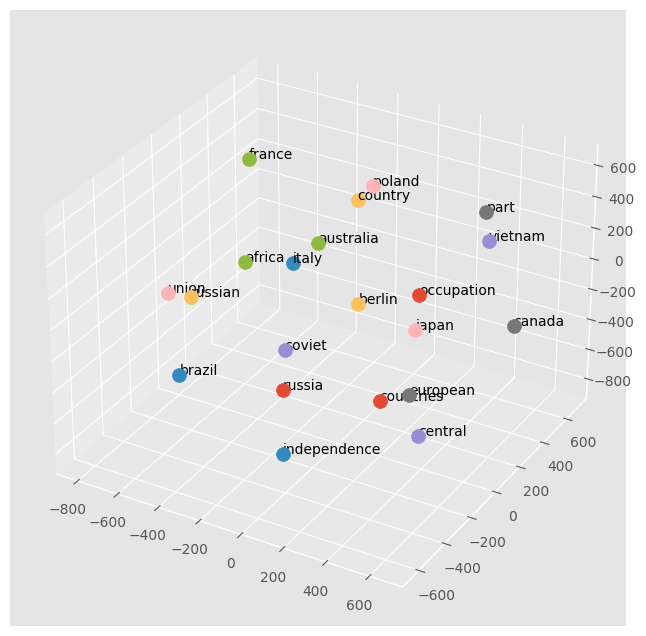

In [137]:
plot3D_with_labels(word='poland', k=20, model= rnn)

--- 
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>